This provides a framework to construct deep neural networks used to efficiently approximating various functions.
* **modular design**: builds on simple network operations and can be easily adapted and extended
* **versatile usage**: convenient mathematical notation and compatible with usual TensorFlow 2.0 modules

Theory: 

* [[1]](https://arxiv.org/abs/1709.05289): *Optimal approximation of piecewise smooth functions using deep ReLU neural networks* - Philipp Petersen, Felix Voigtlaender


* [[2]](https://arxiv.org/abs/1809.07669): *DNN Expression Rate Analysis of High-dimensional PDEs: Application to Option Pricing* - Dennis Elbrächter, Philipp Grohs, Arnulf Jentzen, Christoph Schwab


* [[3]](https://arxiv.org/abs/1902.07896): *Error bounds for approximations with deep ReLU neural networks in $W^{s,p}$ norms* - Ingo Gühring, Gitta Kutyniok, Philipp Petersen


* [[4]](https://arxiv.org/abs/1610.01145): *Error bounds for approximations with deep ReLU networks* - Dmitry Yarotsky


* [[5]](https://arxiv.org/abs/1602.04485): *Benefits of depth in neural networks* - Matus Telgarsky


* [[6]](https://arxiv.org/abs/1905.04992): *Towards a regularity theory for ReLU networks -- chain rule and global error estimates* - Julius Berner, Dennis Elbrächter, Philipp Grohs, Arnulf Jentzen 


* [[7]](https://www.sam.math.ethz.ch/sam_reports/counter/ct.php?file=/sam_reports/reports_final/reports2019/2019-07_fp.pdf): *Deep ReLU Networks and High-Order Finite Element Methods* - Joost Opschoor, Philipp Petersen, Christoph Schwab

## Imports

In [1]:
from __future__ import (absolute_import, division, 
                        print_function, unicode_literals)
%matplotlib inline

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from tensorflow.keras import layers
from tensorflow import nn
tf.keras.backend.clear_session()  # For easy reset of notebook state.

# using files github repository
# !rm -r oberwolfach_workshop # remove folder to download the updated git repository
!git clone https://github.com/juliusberner/oberwolfach_workshop.git

# check tf version and gpu availability
print(tf.__version__)
tf.print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
 
# using helper files
sys.path.append('./oberwolfach_workshop/helper_functions')
from helper_functions import plot_1d, blockdiag

Cloning into 'oberwolfach_workshop'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 101 (delta 0), reused 1 (delta 0), pack-reused 98
Receiving objects: 100% (101/101), 48.91 MiB | 381.00 KiB/s, done.
Resolving deltas: 100% (37/37), done.
2.0.0
Num GPUs Available:  0


## Neural Network Parametrizations, Realizations, and Derivatives  

We follow a mathematical definition due to [P. Petersen and F. Voigtländer [1]](https://arxiv.org/abs/1709.05289):

1. For a given architecture $N=(N_0,\dots,N_L)$ define a neural network parametrization $\Phi$ to be a finite sequence of matrix-vector pairs
    
   $$\color{green} {\Phi:=((W_k,b_k))_{k=1}^L} $$
   
   where  $W_k\in\mathbb{R}^{N_{k-1}\times N_{k}}$ and $b_k\in\mathbb{R}^{N_k}$.
    
    
2. For a given activation function $\rho\colon\mathbb{R}\to\mathbb{R}$ define its realization $\mathcal{R}_\rho\Phi\colon \mathbb{R}^{1\times N_0}\to\mathbb{R}^{1\times N_L}$ by 

    $$\color{green}{\mathcal{R}_\rho\Phi := \mathcal{A}_L\circ \rho \circ\,\mathcal{A}_{L-1}   \circ\ldots\circ \rho\circ\,\mathcal{A}_1}$$ 

  with $\color{green}{\mathcal{A}_k(x):=xW_k + b_k}$ and $\rho$ applied componentwise. 
  
  Note: In order to stay compatible with TensorFlow we multiply the input from left as a row vector.

### Parametrizations

In [2]:
# Parametrization class
class P():

  def __init__(self, name_or_parameters, name='parametrization', eps=1e-6):
    if isinstance(name_or_parameters, str):
      name = name_or_parameters
      name_or_parameters = SimpleParametrizations[name_or_parameters]
    self.eps = eps
    self.name = name
    self.parameters = name_or_parameters

  @property
  def weights(self):
    return [W for W, _ in self.parameters]
  @property
  def biases(self):
    return [B for _, B in self.parameters]
  @property
  def in_dim(self):
    return self.weights[0].shape[0]
  @property
  def arch(self):
    return [self.in_dim]+[len(B) for B in self.biases]
  @property
  def out_dim(self):
    return self.arch[-1]
  @property
  def width(self):
    return max(self.arch)
  @property
  def depth(self):
    return len(self.arch)-1
  @property
  def pa_max(self):
    return max([max(np.max(W),np.max(B)) for W, B in self.parameters])
  @property
  def num_parameters(self):
    return sum([self.arch[i]*self.arch[i+1]+self.arch[i+1] 
                             for i in range(self.depth)])
  @property
  def connectivity(self):
    return sum([(np.abs(W)>self.eps).sum()+(np.abs(B)>self.eps).sum() 
                            for W, B in self.parameters])
    
  def __getitem__(self, idx):
      return self.parameters[idx]

  def __setitem__(self, idx, value):
      self.parameters[idx] = value

  def __repr__(self):
    return str(self.parameters)
  
  def __str__(self):
    return str(self.parameters)

  def attributes_print(self):
    print('Depth: {}, Width: {}, Max: {}, #Parameters: {}, Connectivity: {}'.format(
        self.depth,self.width,self.pa_max, self.num_parameters,self.connectivity))

# Parametrizations of simple functions
SimpleParametrizations = {'abs': [(np.array([[1.,-1]]), np.array([0.,0.])), 
                                  (np.array([[1.],[1.]]), np.array([0.]))],
                          'triangle': [(np.array([[1.,1.,1.]]), 
                                  np.array([0.,-0.5,-1.])), 
                                 (np.array([[2.],[-4.],[2.]]), 
                                  np.array([0.]))]}

----

In [3]:
# 2-layer neural net
A1 = np.array([[1.,2.,3.,4.]])
B1 = np.array([5.,6.,7.,8.])
A2 = np.array([[0.9],[0.10],[0.11],[0.12]])
B2 = np.array([0.13])
Psi = P([(A1,B1),(A2,B2)])

In [4]:
vars(Psi)

{'eps': 1e-06,
 'name': 'parametrization',
 'parameters': [(array([[1., 2., 3., 4.]]), array([5., 6., 7., 8.])),
  (array([[0.9 ],
          [0.1 ],
          [0.11],
          [0.12]]), array([0.13]))]}

In [5]:
Psi.attributes_print()

Depth: 2, Width: 4, Max: 8.0, #Parameters: 13, Connectivity: 13


In [6]:
dir(Psi)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'arch',
 'attributes_print',
 'biases',
 'connectivity',
 'depth',
 'eps',
 'in_dim',
 'name',
 'num_parameters',
 'out_dim',
 'pa_max',
 'parameters',
 'weights',
 'width']

In [7]:
Psi.arch

[1, 4, 1]

In [8]:
Phi = P('triangle')

In [9]:
Phi

[(array([[1., 1., 1.]]), array([ 0. , -0.5, -1. ])), (array([[ 2.],
       [-4.],
       [ 2.]]), array([0.]))]

----

### Realization
* tf: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [10]:
# affine linear layer
# e.g. Affine(W,B)(x)=xW+B
class Affine(layers.Layer):

  def __init__(self, W, B):
    super(Affine, self).__init__()
    self.w = tf.Variable(initial_value=tf.constant(W,dtype='float32'),
                         trainable=True)
    self.b = tf.Variable(initial_value=tf.constant(B,dtype='float32'),
                         trainable=True)

  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

# realization map
class R(tf.keras.Model):

  def __init__(self, name_or_P, act=nn.relu):
    if isinstance(name_or_P, str):
      name_or_P=P(name_or_P)
    super(R, self).__init__(name=name_or_P.name)
    self.parametrization = name_or_P
    self.act = act
    self.affine_maps = [Affine(W, B) 
                        for W, B in self.parametrization.parameters]

  def call(self, input_tensor, training=False):

    x = input_tensor
    for affine in self.affine_maps[:-1]:
      x = affine(x)
      x = self.act(x)
    return self.affine_maps[-1](x)


---

In [11]:
R(Phi)([[0.5]])

<tf.Tensor: id=44, shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [12]:
R(Phi)([[0.2],[0.3],[0.8]]).numpy()

array([[0.4       ],
       [0.6       ],
       [0.39999998]], dtype=float32)

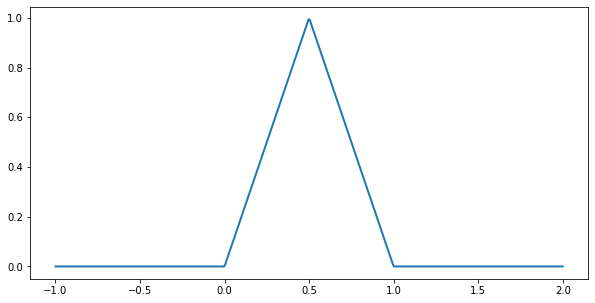

In [13]:
plot_1d(R(Phi), interval=[-1,2])

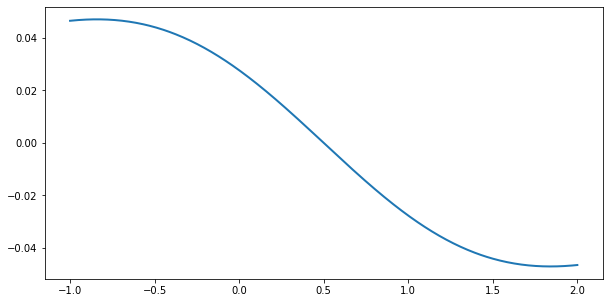

In [14]:
plot_1d(R(Phi, act=nn.sigmoid), interval=[-1,2])

----

### Derivative
* tf: https://www.tensorflow.org/tutorials/customization/autodiff3. 

Define the derivative (w.r.t. the input) $\mathcal{D}_\rho\Phi\colon\mathbb{R}^{1\times N_0}\to\mathbb{R}^{N_L\times N_0}$ by 

  $$\color{green}{\mathcal{D}_\rho\Phi:=W^T_L\cdot \operatorname{diag}(D\rho(\mathcal{R}^{L}_\rho\Phi))\cdot W^T_{L-1}\cdot\ldots\cdot \operatorname{diag}(D\rho(\mathcal{R}_\rho^{1}\Phi))\cdot W_1^T}$$ 
  
  with $\color{green}{\mathcal{R}^K_\rho\Phi:=\mathcal{R}_\rho((W_k,b_k))_{k=1}^{K}}$ and $D\rho$ applied componentwise.

  Note: If $\rho$ is only a.e. differentiable (i.e. locally Lipschitz continuous) we use the extended derivative 

  $$\bar{D}\rho(x) := \begin{cases} D\rho(x), & \rho \text{ is differentiable at } x \\ 0 &\text{else.}  \end{cases} $$

  Then it holds that the classical derivative of the realization function  coincides with the  neural network derivative almost everywhere, i.e. 

  $$\color{green}{\mathcal{D}_\rho\Phi=D\mathcal{R}_\rho\Phi \quad a.e.}$$

  see [[2]](https://arxiv.org/abs/1905.04992). Observe that all realizations with locally Lipschitz continuous activation function are itself locally Lipschitz continuous and a.e. classically differentiable (due to Rademacher's theorem) with its weak derivative a.e. coinciding with its classical derivative.

In [15]:
# derivative map (for now: only supports Pa with Pa.out_dim = 1) 
# dR(Pa)(x)/dx via automatic differentiation
def D(Pa, act=nn.relu):
  def der(x):
    with tf.GradientTape() as t:
      x = tf.convert_to_tensor(x)
      t.watch(x)
      y = R(Pa, act = act)(x)
      return t.gradient(y, x)
  return der

----

In [16]:
D(Phi)([[0.5]]).numpy()

array([[2.]], dtype=float32)

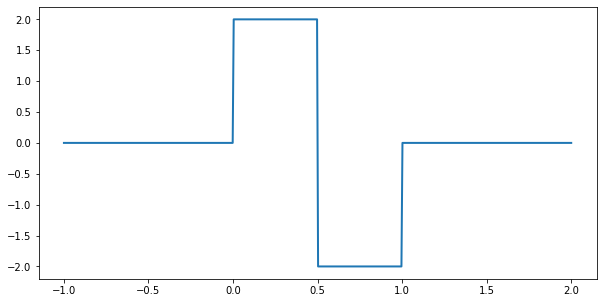

In [17]:
plot_1d(D(Phi), interval=[-1,2])

----

## Operations on Parametrizations

We can define various operations on neural networks parametrizations achieving 
* Concatenation (Composition)
* Parallelization
* Affine Combinations

of the corresponding realization functions, see [[1]](https://arxiv.org/abs/1709.05289), [[2]](https://arxiv.org/abs/1809.07669), [[3]](https://arxiv.org/abs/1902.07896).

For instance, we define the concatenation with $\Psi\!=\!((\tilde{A}_k,\tilde{b}_k))_{k=1}^{\tilde{L}}$ by


 $$\Psi\circ\Phi:=\big(((A_k,b_k))_{k=1}^{L-1},(A_{L}\tilde{A}_1,b_{L}^T\tilde{A}_1 +\tilde{b}_1),((\tilde{A}_k,\tilde{b}_k))_{k=2}^{\tilde{L}}\big)$$


and it holds that $\mathcal{R}_\rho(\Psi\circ\Phi) = \mathcal{R}_\rho(\Psi) \circ\mathcal{R}_\rho (\Phi)$.



In the following we focus on the ReLU activation function $\color{green}{\rho(x)=\operatorname{ReLU}(x):=x_+}$ (and abreviate $\mathcal{D}:=\mathcal{D}_{\operatorname{ReLU}}$, $\mathcal{R}:=\mathcal{R}_{\operatorname{ReLU}}$).

Note that such constructions could be achieved for any piecewise linear activation function with $1\le M <\infty$ breakpoints [[4]](https://arxiv.org/abs/1610.01145) and in an approximative fashion for any activation function that is differentiable and not constant on some open set (as this allows the uniform approximation of the identity function on a compact set).

### NN operations and constructions


In [18]:
# linear network
def Lin(W):
  zeros = np.zeros((W.shape[1],))
  return P([(W,zeros)])

# network concatenation
# e.g. Pa_list = [Pa1, Pa2, Pa3]
# R(Conc(Pa_list))(x)=R(Pa3)(R(Pa2)(R(Pa1)(x)))
# the order is reversed for easier usage
def Conc(Pa_list):
  if len(Pa_list)==1: #catch exceptional cases in other functions
    return Pa_list[0]
  if len(Pa_list)==2:
    Pa1=Pa_list[0]
    Pa2=Pa_list[1]
    W=np.matmul(Pa1.weights[-1],Pa2.weights[0])
    B=np.matmul(Pa1.biases[-1],Pa2.weights[0])+Pa2.biases[0]
    return P(Pa1.parameters[:-1]+[(W,B)]+Pa2.parameters[1:])
  else:
    return Conc([Conc(Pa_list[:-1]),Pa_list[-1]])

# positive elongation (with factor) helper function
def _pos_elong(Pa, L, factor = 1):
  Pa_pos = Identity(Pa.out_dim, 1, scale = factor)
  return P(Pa.parameters+[Pa_pos.parameters[0] for _ in range(L-Pa.depth)])

# (affine) linear combination
# e.g. Pa_list = [P1,P2], coeff_list = [A,B]
# then: R(Affine(Pa_list, coeff_list))(x)=A*R(P1)(x)+B*R(P2)(x))
# see parallelization for explanation of ind_list
def Affine_Comb(coeff_list, Pa_list = None, ind_list = None, affine = None):
  block = np.block([coeff_list]).transpose()
  if affine == None:
    Pa_comb = Lin(block)
  else:
    Pa_comb = P([(block,affine)])
  if Pa_list == None:
    return Pa_comb
  else: 
    return Conc([Par(Pa_list, ind_list=ind_list),Pa_comb])

# identity network with possible efficient scaling
# e.g. dim=2, L=4, scale = np.array([16,81]) 
# then R(Identity(dim, L, scale))(x)=(16x_1,81x_2)
# efficient: coefficients with magnitude |scale_i|**(1/L)
def Identity(dim, L, scale = 1):
  id = np.eye(dim)
  if L==1:
    return Lin(scale*id)
  elif L>1:
    factor = np.abs(scale)**(1/L)
    Pa_list = [_pos_elong(Lin(m), L, factor=factor) 
              for m in [factor*id, -factor*id]]
    ind = np.arange(dim)
    return Affine_Comb([np.sign(scale)*id, -np.sign(scale)*id], Pa_list=Pa_list, ind_list=[ind, ind])
  else:
    raise ValueError('L must be a natural number greater than 0.')

# update SimpleParametrizations
SimpleParametrizations.update({'identity': Identity(1,1).parameters})

# parallelization helper function for same depth
def _par_same(Pa_list):
  if len(Pa_list)==2:
    return P([(blockdiag([W1,W2]),np.block([B1,B2])) 
            for (W1, B1), (W2, B2) 
            in zip(Pa_list[0].parameters,Pa_list[1].parameters)])
  else:
    return _par_same([_par_same(Pa_list[:-1]),Pa_list[-1]])

# parallelization with indexed input
# e.g. Pa_list = [P1,P2], ind_list = [(2,0),(1,3)]
# then: R(Par(Pa_list, ind_list))(x_0,x_1,x_2,x_3)=(R(P1)(x_2,x_0),R(P2)(x_1,x_3))
def Par(Pa_list, ind_list = None, in_dim = None):
  L = max([Pa.depth for Pa in Pa_list])
  Pa = _par_same([Elongation(Pa, L) for Pa in Pa_list])
  if ind_list == None:
    return Pa
  else:
    if in_dim == None:
      in_dim = max([max(ind) for ind in ind_list])+1
    perms = [np.zeros((in_dim, Pa.in_dim)) for Pa in Pa_list]
    for perm, ind in zip(perms, ind_list):
      perm[ind,np.arange(len(ind))] = 1
    Pa_perms = Lin(np.block([perms]))
    return Conc([Pa_perms,Pa])

# sparse network concatenation
def Sparse_Conc(Pa_list):
  if len(Pa_list)==2:
    Id = Identity(Pa_list[0].out_dim, 2)
    return Conc([Pa_list[0],Id,Pa_list[1]])
  else:
    return Sparse_Conc([Sparse_Conc(Pa_list[:-1]),Pa_list[-1]])

# network elongation
def Elongation(Pa, L): 
  if Pa.depth == L:
    return Pa
  else:
    return Conc([Pa,Identity(Pa.out_dim,L-Pa.depth+1)])

----

In [19]:
T, I = P('triangle'), P('identity')

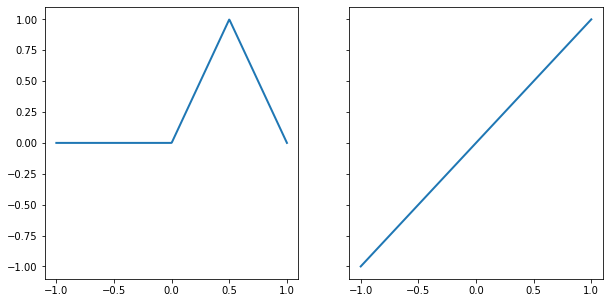

In [20]:
plot_1d(R(T),R(I))

In [21]:
I.attributes_print()

Depth: 1, Width: 1, Max: 1.0, #Parameters: 2, Connectivity: 1


In [22]:
I_long = Elongation(I, 3) # elongation of I to depth 3
T_2 = Conc([T,T]) # composition of T_2 with itself

In [23]:
I_long.attributes_print()

Depth: 3, Width: 2, Max: 1.0, #Parameters: 13, Connectivity: 6


In [24]:
T_2.attributes_print() #I_long and T_2 have same depth now

Depth: 3, Width: 3, Max: 2.0, #Parameters: 22, Connectivity: 19


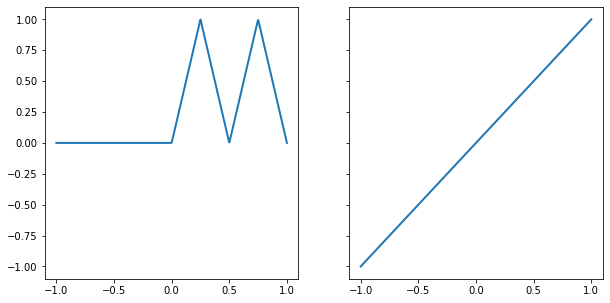

In [25]:
plot_1d(R(T_2),R(I_long))

In [26]:
Pa2 = Affine_Comb([1.,1.], Pa_list=[I_long,T_2], ind_list=[[0],[0]]) 
# addition of realization functions -> outputs I_long(x) + T_2(x)
Pa2

[(array([[ 1., -1.,  1.,  1.,  1.]]), array([ 0. ,  0. ,  0. , -0.5, -1. ])), (array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  2.,  2.],
       [ 0.,  0., -4., -4., -4.],
       [ 0.,  0.,  2.,  2.,  2.]]), array([ 0. ,  0. ,  0. , -0.5, -1. ])), (array([[ 1.],
       [-1.],
       [ 2.],
       [-4.],
       [ 2.]]), array([0.]))]

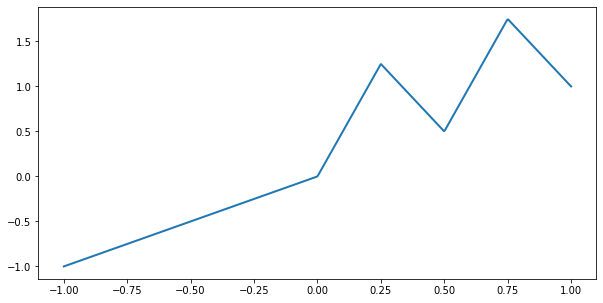

In [27]:
plot_1d(R(Pa2))

In [28]:
Pa2 = Affine_Comb([1.,1.], Pa_list=[I_long,T_2])
# addition of realization functions for seperate inputs (x_1, x_2) -> outputs I_long(x_1) + T_2(x_2)

In [29]:
Pa2.in_dim, Pa2.out_dim

(2, 1)

In [30]:
R(Pa2)([[0.25,0.25]]).numpy() # 2-dimensional input

array([[1.25]], dtype=float32)

In [31]:
R(Pa2)([[1.,0.],[0.25,0.25]]).numpy() # or general: inputs of dimension [batch_size, 2]

array([[1.  ],
       [1.25]], dtype=float32)

In [32]:
D(Pa2)([[0.25,0.25]]).numpy() # derivative of I_long and T_2

array([[1., 4.]], dtype=float32)

----

## Constructive Approximation Results (in $W^{1,\infty}$ norm)

In the following we show how to approximate a richer class of functions by ReLU networks with "almost optimal" rates (in the spirit of Yarotsky [[4]](https://arxiv.org/abs/1610.01145)).

### Telgarsky Saw-Tooth Construction 

*For any positive integer k, there exist neural networks with $\mathcal{O}(k^3)$  layers, $\mathcal{O}(1)$ nodes per layer, and $\mathcal{O}(1)$ distinct parameters which can not be approximated by networks with $\mathcal{O}(k)$ layers unless they are exponentially large --- they must possess $\Omega(2^k)$ nodes [[7]](https://arxiv.org/abs/1602.04485).*

Each application of the triangle ReLU network doubles the number of "theeth"  $\Rightarrow$  $\color{green}{2^k}$ teeth with $\color{green}{\mathcal{O(k)}}$ network size (layers/parameters)

----

In [33]:
interact(lambda k: plot_1d(R(Conc([P('triangle') for _ in range(k)])), 
                            interval=[-0.5,1.5], num=1e+5), k=(1,5));

interactive(children=(IntSlider(value=3, description='k', max=5, min=1), Output()), _dom_classes=('widget-inte…

----

### Yarotsky Squaring Network 

*Proposition 2. The function $f (x) = x^2$ on the segment [0, 1] can be approximated with any
error $\varepsilon > 0$ by a ReLU network having the depth and the number of weights and computation
units $\mathcal{O}(ln(1/\varepsilon))$ [[6]](https://arxiv.org/abs/1610.01145).*

$\big($ lin. interp. of $f$ on intervals of size $2^{-k}$ $\big)$ - $\big($ lin. interp. on intervals of size $2^{-(k+1)}$  $\big) = \big($ scaled saw-thooth function with $2^k$ "theeth" $\big)$

* "on the fly" add the scaled sawthooth functions in an additional node $\Rightarrow$ precision $\color{green}{\mathcal{O}(2^{-k})}$ with ReLU networks of size $\color{green}{\mathcal{O}(k)}$

<img src='oberwolfach_workshop/figures/square_approx.svg'>

In [34]:
# squaring helper function (interpolates the squaring function up to precision 4**(-k))
def _square(k):
  if isinstance(k, int):
    if k<=1:
      return P('identity')
    elif k>1:
      Pa_triang = P('triangle')
      Pa_inp = _pos_elong(P('identity'), 2)
      Pa_sub_list = [_pos_elong(Affine_Comb([-2.**(-2*m),1]), 2) for m in range(1,k-1)]
      Pa_first = Par([Pa_triang, Pa_inp], ind_list=[[0],[0]])
      Pa_middle_list = [Par([Pa_triang, Pa_sub], ind_list=[[0],[0,1]]) 
                          for Pa_sub in Pa_sub_list]
      return Conc([Pa_first]+Pa_middle_list+[Affine_Comb([-2.**(-2*(k-1)),1])])
  
  else:
    raise ValueError('k must be an integer.')

----

In [35]:
square = np.poly1d([1,0,0])
interact(lambda k: plot_1d([R(_square(k)),square], interval=[0,1]), k=(1,5));

interactive(children=(IntSlider(value=3, description='k', max=5, min=1), Output()), _dom_classes=('widget-inte…

----

*...the same construction can be used when measuring the
approximation error in the $W^{1,\infty}$ norm. In particular, the depth and the number of weights and neurons
of the network do not grow asymptotically faster to satisfy the approximation accuracy with respect to
this stronger norm.* [[4]](https://arxiv.org/abs/1902.07896), [[8]](https://www.sam.math.ethz.ch/sam_reports/counter/ct.php?file=/sam_reports/reports_final/reports2019/2019-07_fp.pdf)

Let $f(x)=x^2$. There are ReLU networks $\Phi_\varepsilon$ of size $\color{green}{\mathcal{O(\log(1/\varepsilon))}}$ satisfying $\color{green}{\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((0,1))} \le \varepsilon}$.

----
**Reminder:** 

$$ W^{n,p}(\Omega):= \{g\in L^p(\Omega): D^\alpha g \in L^p(\Omega)  \quad \forall\alpha\in\mathbb{N}_0^d \quad \text{with} \quad |\alpha|\le n\}$$

$D^\alpha g$ is the $\alpha$-th weak derivatives of $g$, if $$\int_{\Omega} g (D^{\alpha} \phi) = (-1)^{|\alpha|} \int_{\Omega} (D^{\alpha} g) \phi$$ for all $\phi\in C^\infty_c(\Omega)$.



$$\|g\|_{W^{n,\infty}(\Omega)}:=\max_{0\le|\alpha|\le n} \|D^{\alpha} g\|_{L^\infty(\Omega)}$$



$\big($ $\Phi$ approximates $f$ in $W^{1,\infty}$ $\big)$ $\Leftrightarrow$ $\big($ $\mathcal{R}(\Phi)$ and its weak gradient uniformly approximate f and the weak gradient of f , respectively $\big)$

----

Next we extent this approximation to the interval $[-B,B]$ (without altering the magnitude of its parameters or the asymptotic size scaling).

<img src='oberwolfach_workshop/figures/square.svg'>

In [36]:
# approximation of squaring function on [-B,B] 
# up to error eps in Sobolev W^{1,\infty} norm
def Square(eps, B = 1.):
  k = int(np.ceil(2*np.log2(B/eps)+1))
  L = int(np.ceil(np.log2(B))) if B>1 else 1
  return Conc([Lin(np.array([[1/B]])),P('abs'),
                _square(k),Identity(1, L, scale=B**2)])

----

In [37]:
# visualization of squaring function approximation
interact(lambda eps: plot_1d([R(Square(eps)),square],
                              [D(Square(eps)),np.polyder(square)], 
                              interval=[-1,1], sharey=False), eps=(0.1,1.));

interactive(children=(FloatSlider(value=0.55, description='eps', max=1.0, min=0.1), Output()), _dom_classes=('…

In [38]:
# exploring the squaring function approximation networks
interact(lambda eps, B: Square(eps, B = B).attributes_print(), 
         eps=(0.01,0.1,0.01), B=(1.,100.));
# note that the parameter magnitude is bounded (by leveraging the depth of the network)

interactive(children=(FloatSlider(value=0.05, description='eps', max=0.1, min=0.01, step=0.01), FloatSlider(va…

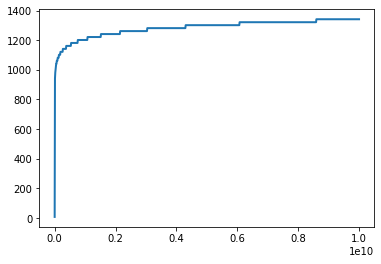

In [39]:
# emprical test of logarithmic parameter scaling
x = np.linspace(1, 1e10, num=1000)
y = [Square(1/eps).num_parameters for eps in x]
plt.plot(x,y,linewidth=2)
plt.show()

----

### Multiplication, Polynomials, and Smooth Functions

Combing (composition, linear combination) the squaring networks (and exactly representable easy networks) one gets 
* networks approximating multiplication: $\color{green}{xy=\left|\frac{x+y}{2}\right|^2-\left|\frac{x-y}{2}\right|^2}$
* polynomials 
* functions whose first $n\geq 1$ (weak) derivatives are bounded: local Taylor approximation



In [40]:
# approximation of multiplication function on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def Mult(eps, B = 1.):
  Pa_list = [Conc([Affine_Comb([1., a]), Square(2*eps, B = 2*B)]) 
            for a in [1.,-1.]]
  return Affine_Comb([0.25,-0.25], Pa_list=Pa_list, ind_list=[[0,1],[0,1]])

<img src='oberwolfach_workshop/figures/mult.svg'>

----

In [41]:
# exploring the networks approximating the multiplication function (on [-1,1]!)
interact(lambda x, y: R(Mult(1e-2, B = 1.))([[x,y]]).numpy(), x=(-1.5,1.5), y=(-1.5,1.5));

interactive(children=(FloatSlider(value=0.0, description='x', max=1.5, min=-1.5), FloatSlider(value=0.0, descr…

----

In [42]:
# approximation of monomials function (x,x^2,...,x^(2^2)) on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def _Monomial(K, eps, B = 1.):
  Pa_list_all=[]
  Pa_id = P('identity')
  eta = eps/(4.**(K**2)*B**(2**(K+1)))
  eta_list = [4**(k**2)*eta for k in range(1,K+1)]  
  E = 2*B**(2**K)
  for k in range(K):
    Pa_list=[]
    ind_list=[]
    Pa_square = Square(eta_list[k], B = E)
    Pa_mult = Mult(eta_list[k], B = E)
    for i in range(2**(k+1)):
      if i<=2**k-1:
        Pa_list.append(Pa_id)
        ind_list.append([i])
      elif i%2:
        Pa_list.append(Pa_square)
        ind_list.append([(i-1)//2])
      else:
        Pa_list.append(Pa_mult)
        ind_list.append([(i-2)//2,i//2])
    Pa_list_all.append(Par(Pa_list, ind_list=ind_list))
  return Conc(Pa_list_all)

# Monomial extension: arbitrary degree deg, optional with constant 1
def Monomial(deg, eps, B=1.0, const=True):
  K = int(np.ceil(np.log2(deg)))
  if const:
    e = np.zeros((deg+1,))
    e[0] = 1
    Pa_zero = P([(np.block([np.zeros((2**K,1)),np.eye(2**K,deg)]),e)])
  else:
    Pa_zero = Lin(np.eye(2**K,deg))
  return Conc([_Monomial(K, eps, B), Pa_zero])

<img src='oberwolfach_workshop/figures/monomials.svg'>

----

In [43]:
# Testing the output
interact(lambda x, const: print(R(Monomial(3, 0.1, B=10., const = const))([[x]]).numpy()), 
         const=True, x=(-10.,10.));

interactive(children=(FloatSlider(value=0.0, description='x', max=10.0, min=-10.0), Checkbox(value=True, descr…

----

In [44]:
# approximation of polynomial p[0]*x^(N-1)+ ... +p[N-1] on [-B,B]
# up to error eps in Sobolev W^{1,\infty} norm
def Poly(p, eps, B = 1.):
  p_len = len(p)
  coeff_sum = np.sum(np.abs(p))
  eta = eps/coeff_sum
  L = int(np.ceil(np.log2(coeff_sum)))
  Pa_scale = Identity(p_len, L, scale=p[::-1])
  return Conc([Monomial(p_len-1, eta, B), Pa_scale, 
               Affine_Comb(np.ones((1,p_len)))])

----

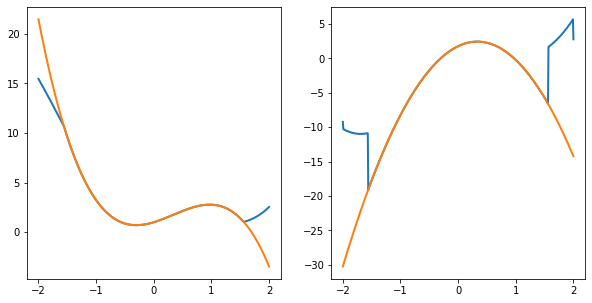

In [45]:
# visualization of polynomial approximation
p=[-2.,2.,1.77,1.]
poly = np.poly1d(p)
Pa = Poly(p, eps=1.) #as this are worst case estimates, eps can be rather large
plot_1d([R(Pa), poly],[D(Pa), np.polyder(poly)], interval=[-2,2], sharey=False)

In [46]:
Pa.attributes_print()

Depth: 34, Width: 16, Max: 4.0, #Parameters: 3325, Connectivity: 771


----

### Theoretical Results 

**...for classes of Sobolev-regular functions:** [[4]](https://arxiv.org/abs/1902.07896)

There exists $c=c(d,n,B)> 0$ such that for every $\varepsilon > 0$ and every
$$f\in\{g\in W^{n,\infty}((0,1)^d): \|g\|_{W^{n,\infty}((0,1)^d)}\le B\}$$
there exists a ReLU network $\Phi$ with
$$\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((0,1)^d)} \le \varepsilon$$
and
$$Depth(\Phi)\le c \cdot log(\varepsilon^{-n/(n-1)}), \quad Connectivity(\Phi)\le  c \cdot \varepsilon^{-d/(n-1)} \cdot log^2(\varepsilon^{-n/(n-1)}).$$

Corresponding results for:

* fractional Sobolev spaces $W^{s,p}$ with $0\le s \le 1$ (Banach space interpolation argument) and $1\le p \le \infty$
* any continuous piecewise linear activation function with $1\le M < \infty$ breakpoints
* lower bound: $Connectivity(\Phi)\ge  c \cdot \varepsilon^{-d/2(n-1)}$


In [47]:
# You can try to construct this networks (perhaps for d=1) using our framework
# 1. construct partition of unity
# 2. predefine derivatives of f (or use automatic differentiation frameworks)
# 3. use the neural network approximating polynomials
#
#
#
#
#
#
#
#
#
#
#
#

## Additional Material

### ReLU derivative

**Problem: Classical Chain-Rule fails!**

...although all ReLU networks are a.e. differentiable.

Very simple counterexample: 

$u(x):=\operatorname{ReLU}(x)$

$v(x):=0$ 

formally apply the chain rule: $$D(u\circ v)(x)=\color{blue}{D u(v(x))}\cdot D v(x)$$

$D u(y)$ is well-defined for all $y\neq 0$, but the expression $\color{blue}{D u(v(x))}$ is not defined for any $x\in\mathbb{R}$.


**Inner function maps a set of positive measure into a set where the derivative of the outer function does not exist.**


**What happens in PyTorch / Tensorflow when computing the gradients in the back-propagation (as this is based on the chain-rule)??**

----

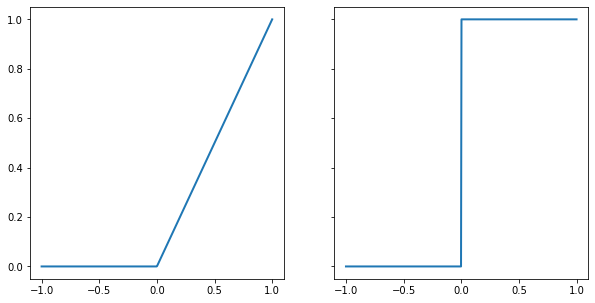

In [48]:
ReLU=P([(np.array([[1.]]),np.array([0.])),(np.array([[1.]]),np.array([0.]))])
plot_1d(R(ReLU),D(ReLU))

In [49]:
D(ReLU)([[0.]]).numpy()

array([[0.]], dtype=float32)

----

The derivative of the ReLU at zero is set to zero in PyTorch and Tensorflow, i.e.
$\color{blue}{\frac{\partial \operatorname{ReLU}}{\partial x}(x) :=1_{(0,\infty)}(x)}$

Note that the chain rule holds by definition everywhere, i.e. 

 $$\color{green}{\mathcal{D}(\Psi\circ\Phi)=\mathcal{D}\Psi(\mathcal{R}\Phi)\cdot\mathcal{D}\Phi}$$

and, furthermore, $\color{green}{\mathcal{D}\Phi=D\mathcal{R}\Phi \quad a.e.}$



**However:** On the nullset the derivative can be arbitrary wrong, e.g. take the network $\Phi=\left(\left( (1 , -1 ),(0 ,0)\right),\left( \left(\begin{matrix} a \\-b \end{matrix}\right),0\right)\right)$ then it holds:

1. $\mathcal{R}\Phi(x)=a\operatorname{ReLU}(x)-b\operatorname{ReLU}(-x)=\begin{cases}  bx, &x< 0 \\  ax, &x\ge 0 \end{cases}$
2. $ \mathcal{D}\Phi(x)=\begin{cases}  b, &x< 0 \\  a, & x> 0 \\ \color{blue}0, & x=0\end{cases}$

----

In [50]:
def plot_print(a, b):
    Pa = P([(np.array([[1.,-1.]]),np.array([0,0])), 
            (np.array([[a],[-b]]), np.array([0.]))])
    plot_1d(R(Pa),D(Pa), sharey=False)
    print('Derivative at x=0: {}'.format(D(Pa)([[0.]])))

interact(plot_print, a=(1.,2.), b=(1.,2.));

interactive(children=(FloatSlider(value=1.5, description='a', max=2.0, min=1.0), FloatSlider(value=1.5, descri…

----

For convex $\mathcal{R}\Phi$ the values of $\mathcal{D}\Phi$ on the nullset do not necessarily lie in the respective subdifferentials of $\mathcal{R}\Phi$.

The next figure illustrates this by showing the behavior of the (backpropagated) derivative of the neural network approximating the squaring function.
<img src='oberwolfach_workshop/figures/squaring_der.png'>

Although our results hold regardless of which value is chosen for the derivative of $\operatorname{ReLU}$ at the origin, no choice will guarantee that all values of $\mathcal{D} \Phi$ lie in the respective subdifferentials of $\mathcal{R}\Phi$ (e.g., additionally consider $x \mapsto ReLU(-ReLU(x))$)

### Global (Pointwise) Error Estimates

For suitable functions $f$ with at most polynomially growing derivative we want ReLU networks $\Phi_\varepsilon$ with:


$$ 
|f(x)-\mathcal{R}{\Phi_\varepsilon}(x)|\le \varepsilon(1+\|x\|^{\kappa}_2) \quad \color{blue}{x\in\mathbb{R}^d}
$$
$$
    \|D f(x) -\mathcal{D}\Phi_\varepsilon(x)\|_2 \le C\varepsilon^r(1+\|x\|_2^{\kappa}) \quad \color{blue}{a.e. \ x\in\mathbb{R}^d}
$$

Idea:
1. ReLU networks $\Phi_{\varepsilon,B}$ with $\|\mathcal{R}\Phi-f \|_{W^{1,\infty}((-B,B)^d)} \le \varepsilon$
2.  ReLU network $\Phi_B^{\operatorname{char}}$ which represents the $d$-dimensional approximate characteristic function of $[-B,B]^d$ [[3]](https://arxiv.org/abs/1809.07669)
3. ReLU network $\Phi_{\varepsilon,b}^{\operatorname{mult}}$ approximating the multiplication function on $[-b,b]^2$ with error $\varepsilon$
4. Define the global approximation networks $\Phi_\varepsilon$ as the composition of $\Phi_{\varepsilon/2,b_\varepsilon}^{\operatorname{mult}}$ with the parallelization of $\Phi_{B_\varepsilon}^{\operatorname{char}}$ and $\Phi_{\varepsilon/2,B_\varepsilon+1}$ for suitable 

\begin{equation}
    B_\varepsilon\in \mathcal{O}(\varepsilon^{-1}) \quad \text{and} \quad b_\varepsilon\in \mathcal{O}(\varepsilon^{-\nu}).
\end{equation}


In [51]:
# You can also try to construct this networks (perhaps for d=1) using our framework
#
#
#
#
#
#
#
#
#
#
#
#